In [1]:
import os
import glob
import json

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1. Download dataset from https://github.com/abdoelsayed2016/HKR_Dataset and splitting from https://github.com/bosskairat/Dataset. 
2. Create root directory '../input/hkr'
3. Put dataset into the root directory and unzip it 

In [2]:
ROOT = '../input/hkr/20200923_Dataset_Words_Public'
SPLITTING = '../input/hkr/HKR_splitting.csv'
IMG_FOLDER = f'{ROOT}/img'
ANN_FOLDER = f'{ROOT}/ann'

In [3]:
def load_json(path):
    with open(path, 'r') as f:
        json_file = json.load(f)
    return json_file
    
def load_annotations(folder):
    files = glob.glob(ANN_FOLDER + '/*.json')
    jsons = []
    for file in files:
        json_file = load_json(file)
        jsons.append(json_file)
    return jsons

In [26]:
annotations = load_annotations(ANN_FOLDER)

In [27]:
%%time

df = pd.DataFrame()

for ann in annotations:
    row = {
        'sample_id': ann['name'],
        'text': ann['description'],
        'path': f'hkr/images/{ann["name"]}.jpg',
    }
    df = df.append(row, ignore_index=True)

CPU times: user 12min 11s, sys: 360 ms, total: 12min 12s
Wall time: 12min 12s


In [28]:
df = df.set_index('sample_id')
df[:3]

,path,text
sample_id,,
7_42_450,hkr/images/7_42_450.jpg,таинственным желаньем;
1_28_104,hkr/images/1_28_104.jpg,ты
2_51_124,hkr/images/2_51_124.jpg,язвительным своим


In [29]:
split = pd.read_csv(SPLITTING).set_index('id')
split['stage'].unique()

array(['train', 'val', 'test1', 'test2'], dtype=object)

In [30]:
train_idxs = split[split['stage'] == 'train']
test_idxs = split[(split['stage'] == 'test1')|(split['stage'] == 'test2')]
valid_idxs = split[split['stage'] == 'val']

In [31]:
train_df = df[df.index.isin(train_idxs.index)]
train_df['stage'] = 'train'
test_df = df[df.index.isin(test_idxs.index)]
test_df['stage'] = 'test'
valid_df = df[df.index.isin(valid_idxs.index)]
valid_df['stage'] = 'valid'

train_df.shape, test_df.shape, valid_df.shape

((45559, 3), (10009, 3), (9375, 3))

In [32]:
result_df = train_df.append(test_df.append(valid_df))
print(result_df.shape)
result_df[:5]

(64943, 3)


,path,text,stage
sample_id,,,
1_28_104,hkr/images/1_28_104.jpg,ты,train
2_51_124,hkr/images/2_51_124.jpg,язвительным своим,train
6_30_413,hkr/images/6_30_413.jpg,и ты ушла из дому.,train
13_13_180,hkr/images/13_13_180.jpg,Шымкент,train
10_13_304,hkr/images/10_13_304.jpg,ПАВЛОДАР,train


In [21]:
os.makedirs('prepared_datasets/hkr/', exist_ok=True)
os.makedirs('prepared_datasets/hkr/images', exist_ok=True)

In [23]:
%%time

!find ../input/hkr/20200923_Dataset_Words_Public/img -type f -name "*.jpg" -exec cp {} ./prepared_datasets/hkr/images/ \; 

CPU times: user 11.9 s, sys: 1.77 s, total: 13.7 s
Wall time: 5min 4s


hkr/images/3_42_238.jpg
stage: train
text: смолкнул бы он.
image_shape: (62, 535, 3)


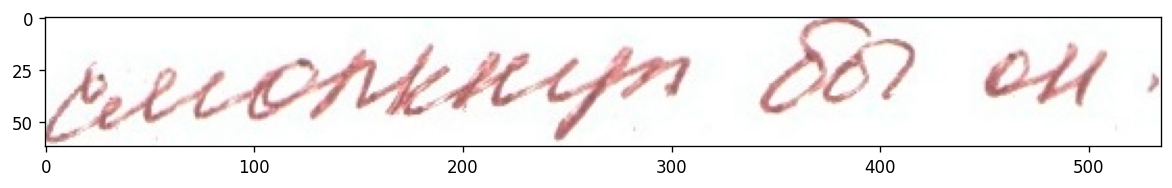

In [33]:
idx = 1234

sample = result_df.iloc[idx]
image_id = sample.name
print(sample.path)
image = cv2.imread(f'./prepared_datasets/{sample.path}')
text = sample['text']

print('stage:', sample['stage'])
print('text:', text)
print('image_shape:', image.shape)

plt.figure(num=None, figsize=(12, 3), dpi=120, facecolor='w', edgecolor='k')
plt.imshow(image);

In [34]:
result_df.to_csv('./prepared_datasets/hkr/marking.csv')

In [35]:
!cd ./prepared_datasets && ls hkr

images	marking.csv


In [36]:
!cd ./prepared_datasets && tar -czvf hkr.tar.gz hkr > /dev/null

In [37]:
!du -sh ./prepared_datasets/hkr.tar.gz

656M	./prepared_datasets/hkr.tar.gz
